# Ondřejov Spectra Preprocessing

This work aims to find correct preprocessing techniques for spectral data
from [Ondřejov CCD700 archive][ccd].
These preprocessing method as cleaning, balancing, scaling should help
to increase classification accuracy of a neural network.
Furthermore, it also seek to get more insight into application of machine
learning to spectral data
because there is the [LAMOST spectra survey][lamost]
which contains vast amount of unexplored data of this kind.

[ccd]: http://voarchive.asu.cas.cz/ccd700/q/web/form
[lamost]: http://www.lamost.org/public/?locale=en

The Jupyter notebook is divided into following parts.
Firstly, visualization of spectral data are presented.
Then data cleaning followed by experiments with scaling
and balancing methods.
Meanwhile, all experiments are validated using neural network classifier.

In [1]:
import itertools
import numpy
import pandas
import seaborn
from matplotlib import pyplot
from astropy.io import fits
from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

In [2]:
seaborn.set_style('ticks')

## Ondřejov Dataset

Ondřejov dataset contains 12936 labeled stellar spectra from
Ondřejov CCD700 archive.
The spectra were observed with Ondřejov Perek 2m Telescope
and the observations were primarily focused on Be stars.

For complete information about the Ondřejov dataset
and corresponding code visit its [GitHub repository][dataset].

[dataset]: https://github.com/podondra/ondrejov-dataset

In [3]:
spectra = pandas.read_csv('ondrejov-dataset.csv', index_col='id')
spectra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12936 entries, a201305230017 to we200016
Columns: 151 entries, dec to 6732.0
dtypes: float64(142), int64(2), object(7)
memory usage: 15.0+ MB


### Metadata

The dataset contains some metadata from which the most interesting is
the *label* attribute:

- *id*: unique identifier (FITS file name)
- *label*: assigned class
- *object*: title of observation
- *ra*: right ascension
- *dec*: declination
- *expval*: exposure value in photon counts (Mcounts)
- *gratang*: diffraction grating angle
- *detector*: name of the detector
- *chipid*: name of CCD chip
- *specfilt*: spectral filter
- *date-obs*: UTC date start of observation
- *dichmir*: dichroic mirror number

In [4]:
spectra.iloc[:, :11].head()

,dec,gratang,detector,expval,object,dichmir,chipid,ra,specfilt,label,date-obs
id,,,,,,,,,,,
a201305230017,-11:09:40.70,30.25,PyLoN 2048x512BX,19.246130,alp Vir,2,E2V 42-10 BX,13:25:11.580,1,absorption,2013-05-23
a201306060015,+19:10:56.60,30.25,PyLoN 2048x512BX,0.009187,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,2013-06-06
a201306060016,+19:10:56.60,30.25,PyLoN 2048x512BX,0.012332,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,2013-06-06
a201306060018,+33:21:45.60,30.25,PyLoN 2048x512BX,5.056532,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,2013-06-06
a201306060019,+33:21:45.60,30.25,PyLoN 2048x512BX,15.040130,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,2013-06-06


Figure below shows distribution of 30 most frequent object contained in the dataset.
For example HD 91316 has more than 400 spectra in the dataset.
This might be potential problem because the spectra from an object
might be very similar so the test split should be aware of that.

There is 1306 distinct objects in the dataset.
There is 12936 different spectra in the dataset


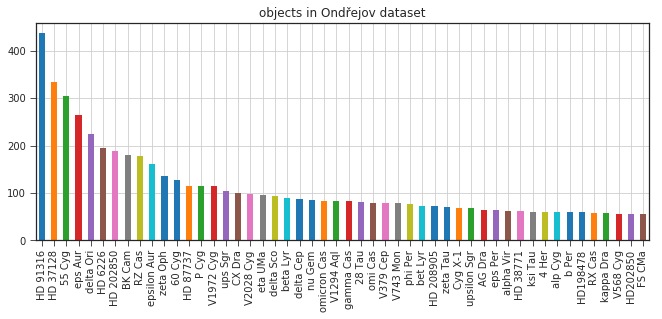

In [5]:
f, ax = pyplot.subplots(figsize=(11, 4))
ax.set_title('objects in Ondřejov dataset')
spectra['object'].value_counts().nlargest(50).plot.bar(ax=ax, grid=True)

n_objects = spectra['object'].nunique()
print('There is {} distinct objects in the dataset.'.format(n_objects))
print('There is {} different spectra in the dataset'.format(len(spectra)))

### Labels

Spectra are divided into 3 classes according to profile of
the [H-alpha spectral line][halpha].

The *absorption* in H-alpha is feature of ordinary star.
The interest is focused on the *emission* or *double-peak* star
which are rare yet unexplored objects in the universe.

[halpha]: https://en.wikipedia.org/wiki/H-alpha

For better processing the label strings are converted to numerical
value in range from 0 to 2.

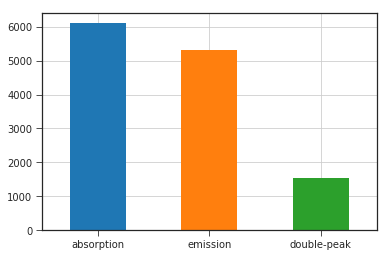

In [6]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(spectra['label'])
spectra['label'].value_counts().plot.bar(rot=0, grid=True)

### Spectral Data

Rest of dataset columns are the flux values for each spectrum.
There is exactly 140 measurement for each spectrum.
Each of the 140 features is floating point number
and they have same scale.
A useful analogy is to thing of spectrum as 1 dimensional image.
Thus, we can applied most of machine learning knowledge from image classification.
While experimenting with the dataset these column are the one
to which preprocessing method should be applied.
Therefore, the design matrix $X$ is created from them.

In [7]:
X = spectra.iloc[:, 11:].as_matrix()
X.shape

(12936, 140)

## Data Visualization

This section presents visualization of random spectra from the dataset.
A spectrum consist of fluxes at certain wavelengths.
Wavelengths are given in [Angstroms](https://en.wikipedia.org/wiki/%C3%85ngstr%C3%B6m)
and flux is a value somehow related to number of electron in each
bank of spectrograph's chip.

It can be observed that the flux values significantly varies
which depends on the exposition time and other factors.
This might be a potential problem as the data were classified
according to shape at H-alpha line so the intensities should
be irrelevant.

Figures also show position vacuum H-alpha wavelength where is
the spectral line according to which the data where classified.

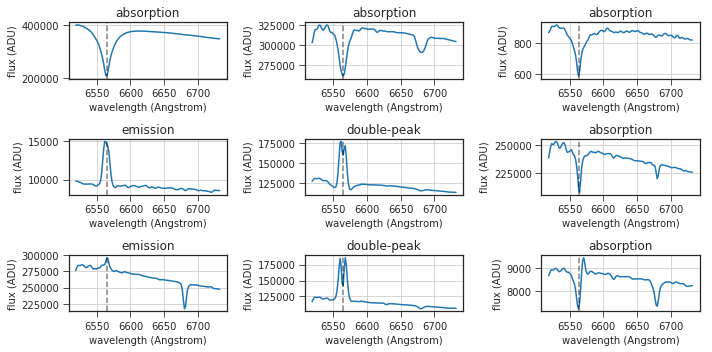

In [8]:
# http://classic.sdss.org/dr7/products/spectra/vacwavelength.html
HALPHA = 6564.614
# wavelengths from https://github.com/podondra/ondrejov-dataset
WAVES = numpy.linspace(6519, 6732, 140)

def plot_flux(flux, title=None, ax=None):
    if ax is None:
        ax = pyplot.subplot()

    ax.plot(WAVES, flux)
    ax.set_ylabel('flux (ADU)')
    ax.set_xlabel('wavelength (Angstrom)')
    ax.axvline(HALPHA, color='black', linestyle='dashed', alpha=0.5)
    ax.grid()
    
    if title is not None:
        ax.set_title(title)

nrows = 3
ncols = 3
n_idxs = nrows * ncols
rnd_idxs = numpy.random.choice(len(X), size=n_idxs, replace=False)
f, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for ax, idx in zip(axes.flat, rnd_idxs):
    plot_flux(X[idx], title=spectra.iloc[idx]['label'], ax=ax)
f.tight_layout()

Figure below compares original spectrum and corresponding spectrum
for the Ondřejov dataset.
Dataset contains only short part of the spectrum
and has much less detail.
This is due to some preprocessing techniques that are applied
during dataset creation (refer to dataset repository).
A trend can also be observed in the original spectrum
which is caused by [black-body radiation](https://en.wikipedia.org/wiki/Black-body_radiation).

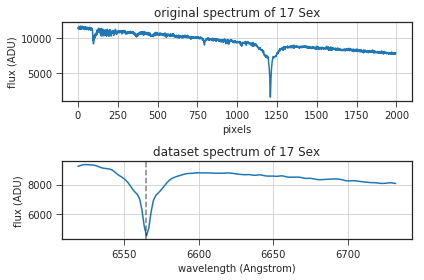

In [9]:
f, (ax1, ax2) = pyplot.subplots(nrows=2)
with fits.open('ua280060.fits') as hdulist:
    header = hdulist[0].header
    data = hdulist[0].data
    ax1.set_title('original spectrum of ' + header['OBJECT'])
    ax1.plot(data)
    ax1.set_xlabel('pixels')
    ax1.set_ylabel('flux (ADU)')
    ax1.grid()
plot_flux(
    spectra.loc['ua280060'].iloc[11:].as_matrix(),
    title='dataset spectrum of ' + spectra.loc['ua280060', 'object'],
    ax=ax2
)
f.tight_layout()

## Dimensionality Reduction

This section uses dimensionality reduction to gain insights into the data
and also to clean the data labels (find incorrectly classified spectra).

### Principal Component Analysis

PCA reveals a scaling problem
because it is important to scale data when using it.
Refer to figure below which does not use scaling.
Usually each feature column is scaled separately to have unit mean
and zero variance (standardization).
But spectra features are on the same scale.
They are all from the same domain (flux in ADU).

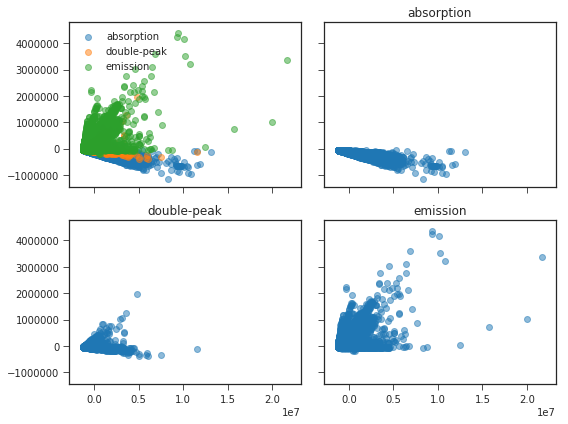

In [10]:
def plot_projection(X):
    f, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(
        nrows=2, ncols=2,
        sharex=True, sharey=True,
        figsize=(8, 6)
    )

    for label, (ax, cls) in enumerate(zip((ax2, ax3, ax4), le.classes_)):
        ax1.scatter(X[y == label, 0], X[y == label, 1], label=cls, alpha=0.5)
        ax.set_title(cls)
        ax.scatter(X[y == label, 0], X[y == label, 1], alpha=0.5)
    ax1.legend(loc='upper left')

    f.tight_layout()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
plot_projection(X_pca)

The figure above much more present the intensity distribution of spectra
than their shape which is the interesting thing.
Below are two spectra selected according to position in PCA scatter plot
(shown on the right side of each spectrum).
It is clear that the two principal components depends on flux intensities.

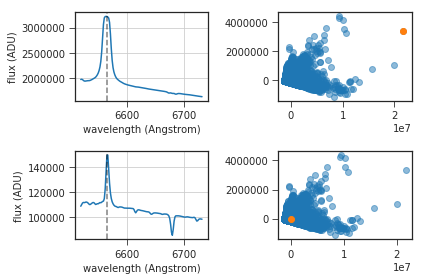

In [11]:
f, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(nrows=2, ncols=2)

# spectrum far from (0, 0)
idx_high = numpy.argmax(numpy.sum(numpy.abs(X_pca[:, :2]), axis=1))
plot_flux(X[idx_high], ax=ax1)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
ax2.scatter(X_pca[idx_high, 0], X_pca[idx_high, 1])

# spectrum closes to (0, 0)
idx_low = numpy.argmin(numpy.sum(numpy.abs(X_pca[:, :2]), axis=1))
plot_flux(X[idx_low], ax=ax3)
ax4.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
ax4.scatter(X_pca[idx_low, 0], X_pca[idx_low, 1])

f.tight_layout()

Given those reason standard scaling is employed for
purpose of PCA
(for classification different methods are going to be evaluated).
But since the features are of same domain the scaling is done
to each spectrum rather than for each feature column.
Therefore the shape of spectrum is the same but the intensities are reduced.
Figures below show a random scaled spectrum in comparison to original one
from the dataset
and visualization of PCA on scaled spectra.

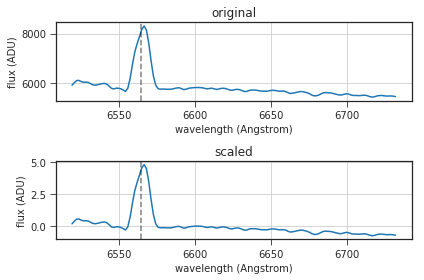

In [12]:
X_scaled = preprocessing.scale(X, axis=1)
idx = numpy.random.randint(len(X))
f, (ax1, ax2) = pyplot.subplots(nrows=2)
plot_flux(X[idx], title='original', ax=ax1)
plot_flux(X_scaled[idx], title='scaled', ax=ax2)
f.tight_layout()

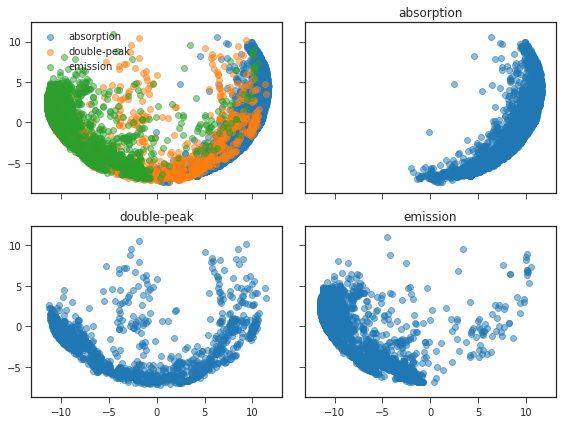

In [13]:
pca = PCA(n_components=3)
X_scaled_pca = pca.fit_transform(X_scaled)
plot_projection(X_scaled_pca)

The variant of PCA with scaling show nice properties of the dataset.
It can be inferred that it is easy to separate emission
from absorption spectra
but double-peak spectra are similar to other classes
so they are mix up with them in the scatter plot.

There is also a large portion of emission spectra in absorption
part of the scatter plot.
A visualization of them is in figure below
(all spectra with first principal component bigger than 0).
They have emission in absorption so they are interesting and in emission class
but also similar to absorption spectra.

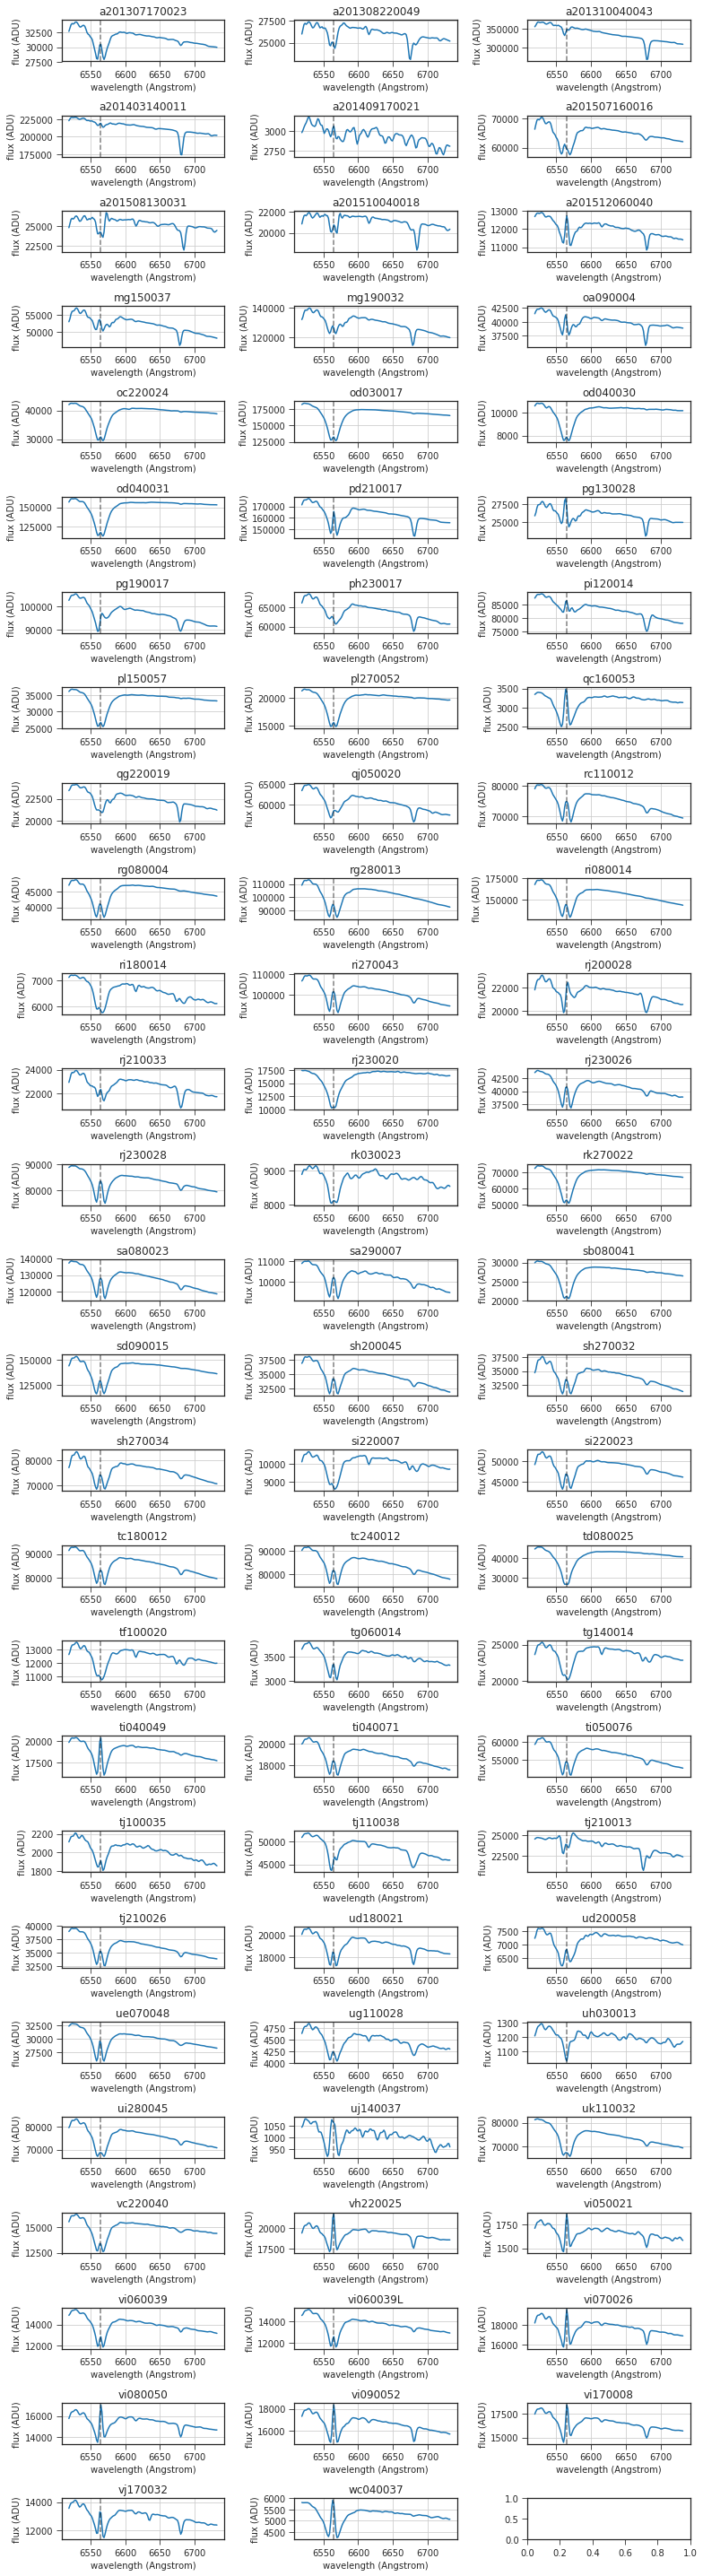

In [14]:
suspect_idxs = numpy.argwhere((y == le.transform(['emission'])) & (X_scaled_pca[:, 0] > 0)).ravel()

f, axes = pyplot.subplots(
    nrows=(len(suspect_idxs) + 1) // 3,
    ncols=3,
    figsize=(11, len(suspect_idxs) // 2)
)
for ax, idx in zip(axes.flat, suspect_idxs):
    plot_flux(X[idx], title=spectra.index[idx], ax=ax)
f.tight_layout()

### t-distributed Stochastic Neighbor Embedding

t-distributed Stochastic Neighbor Embedding ([t-SNE]) is
a technique for non-linear dimensionality reduction
from manifold learning area.
Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high. ([sklearn])

[t-sne]: https://lvdmaaten.github.io/tsne/
[sklearn]: http://scikit-learn.org/stable/modules/manifold.html

Result of t-SNE are in figure below.
It should same thing as PCA but the double-peak spectra look more
separeted.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12936 samples in 0.114s...
[t-SNE] Computed neighbors for 12936 samples in 11.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12936
[t-SNE] Computed conditional probabilities for sample 2000 / 12936
[t-SNE] Computed conditional probabilities for sample 3000 / 12936
[t-SNE] Computed conditional probabilities for sample 4000 / 12936
[t-SNE] Computed conditional probabilities for sample 5000 / 12936
[t-SNE] Computed conditional probabilities for sample 6000 / 12936
[t-SNE] Computed conditional probabilities for sample 7000 / 12936
[t-SNE] Computed conditional probabilities for sample 8000 / 12936
[t-SNE] Computed conditional probabilities for sample 9000 / 12936
[t-SNE] Computed conditional probabilities for sample 10000 / 12936
[t-SNE] Computed conditional probabilities for sample 11000 / 12936
[t-SNE] Computed conditional probabilities for sample 12000 / 12936
[t-SNE] Computed conditional probabilities for sa

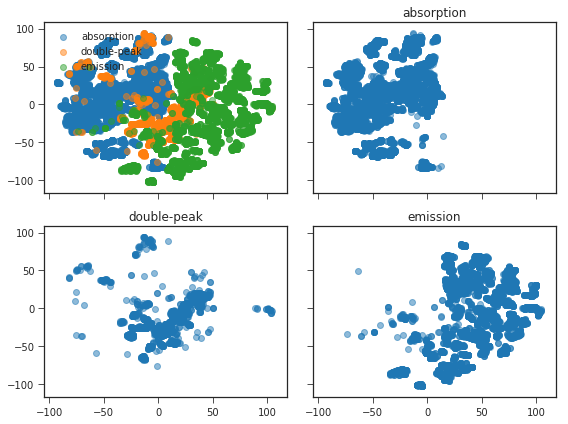

In [15]:
X_tsne = TSNE(n_components=2, verbose=1).fit_transform(
    preprocessing.scale(X, axis=1)
)
plot_projection(X_tsne)

To conclude unsupervised dimensionality reduction,
it should be easy to separate emission from absorption spectra
except some that has emission in absorption.
On the other hand much more challenging task is to
classified correcly double-peak spectra which are mix up
with both other classes when visualized with dimesnisonality reduction tools.

### Linear Discriminant Analysis

Last dimensionality reduction method tried in this work is LDA
which is supervised dimensionality reduction.
Figure below shows that the information about class significantly
improves separation of double-peak spectra.
But in the scatter plot middle there is still large overlap.

The figure also shows a some data points plotted in
totally wrong part of plot, which seems to belong to another class.
Next section examines such points
in order to find why are they mapped to these regions.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


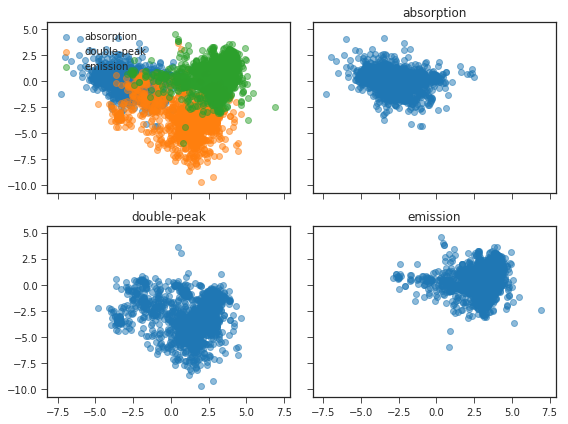

In [16]:
X_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(
    preprocessing.scale(X, axis=1), y
)
plot_projection(X_lda)

## Data Cleaning

This section aim to find some missing values or inconsistences in the data
and also examine strange points find by LDA dimensinality reduction
because these spectra might be possibly missclassified.

Statisctic below shows that there are only four object in the dataset
that are without object name.

In [17]:
spectra.isnull().sum().sum(), spectra['object'].isnull().sum()

(4, 4)

Figure below vizualizes the spectra without object name.
There is nothing strange about them
so they are kept in the dataset.

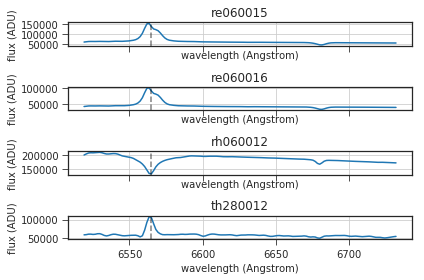

In [18]:
nan_objs = spectra[spectra['object'].isnull()]
f, axes = pyplot.subplots(nrows=len(nan_objs), sharex=True)
for ax, (i, spectrum) in zip(axes, nan_objs.iterrows()):
    plot_flux(spectrum[11:], title=i, ax=ax)
f.tight_layout()

### Suspected Spectra

This section tries to examine some of the spectra concerns in
Linear Discriminant Analysis section.
The notion is that cause they map into regions were is majority
of other class they might possibly be missclassified.

The workflow is following.
The cell bellow which is commeted about contains code which produces
interactive visualization of LDA with id text label added to each point.
So by zoomin to the point of iterest those suspected spectra can be
identified by id. That the spectra are plotted and reclassified.

In [19]:
def plot_ids(ids):
    f, axes = pyplot.subplots(
        nrows=(len(ids) + 2) // 3,
        ncols=3,
        figsize=(11, 2 * ((len(ids) + 2) // 3))
    )
    for ax, i in zip(axes.flat, ids):
        idx = spectra.index == i
        plot_flux(X[idx][0], title=i, ax=ax)
    f.tight_layout()

In [20]:
# %matplotlib nbagg
# f, axes = pyplot.subplots(ncols=3, figsize=(9, 4), sharex=True, sharey=True)
# for label, (ax, cls) in enumerate(zip(axes, le.classes_)):
#     idx = y == label
#     ax.set_title(cls)
#     ax.scatter(X_lda[idx, 0], X_lda[idx, 1], label=cls, alpha=0.5)
#     for i, a, b in zip(spectra.index[idx], X_lda[idx, 0], X_lda[idx, 1]):
#         ax.annotate(i, xy=(a, b), xytext=(a, b))

Following figures vizualize the suspected spectra
which might be missclassified.
Indeed there is 6 incorrectly classified spectra
so their labels in the dataset are modified.

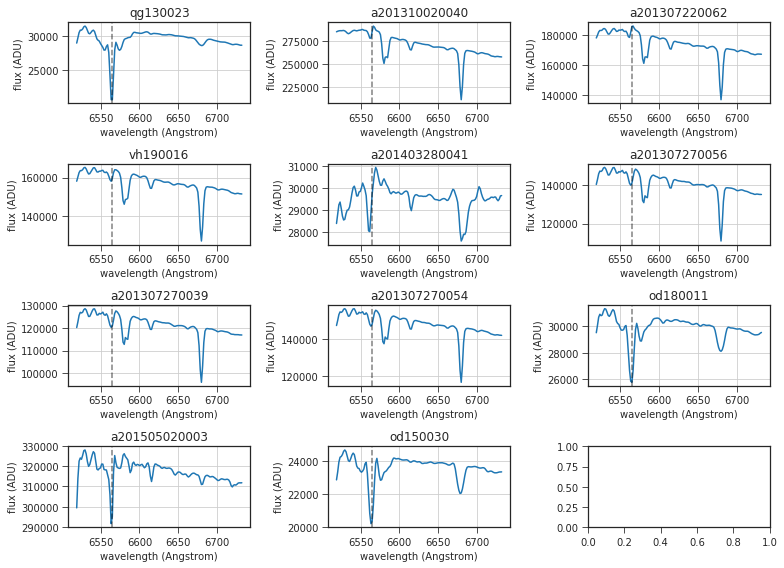

In [21]:
absorptions = [
    'qg130023', 'a201310020040', 'a201307220062',
    'vh190016', 'a201403280041', 'a201307270056',
    'a201307270039', 'a201307270054', 'od180011',
    'a201505020003', 'od150030'
]
plot_ids(absorptions)

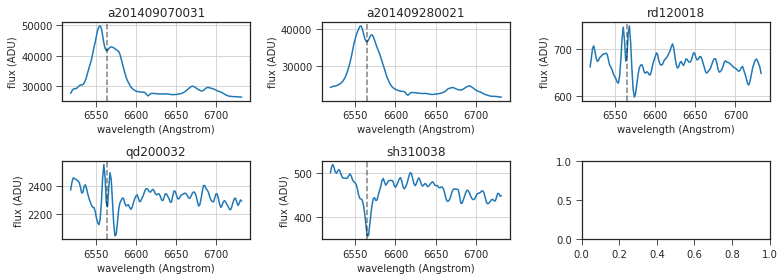

In [22]:
double_peaks = ['a201409070031', 'a201409280021', 'rd120018', 'qd200032', 'sh310038']
plot_ids(double_peaks)

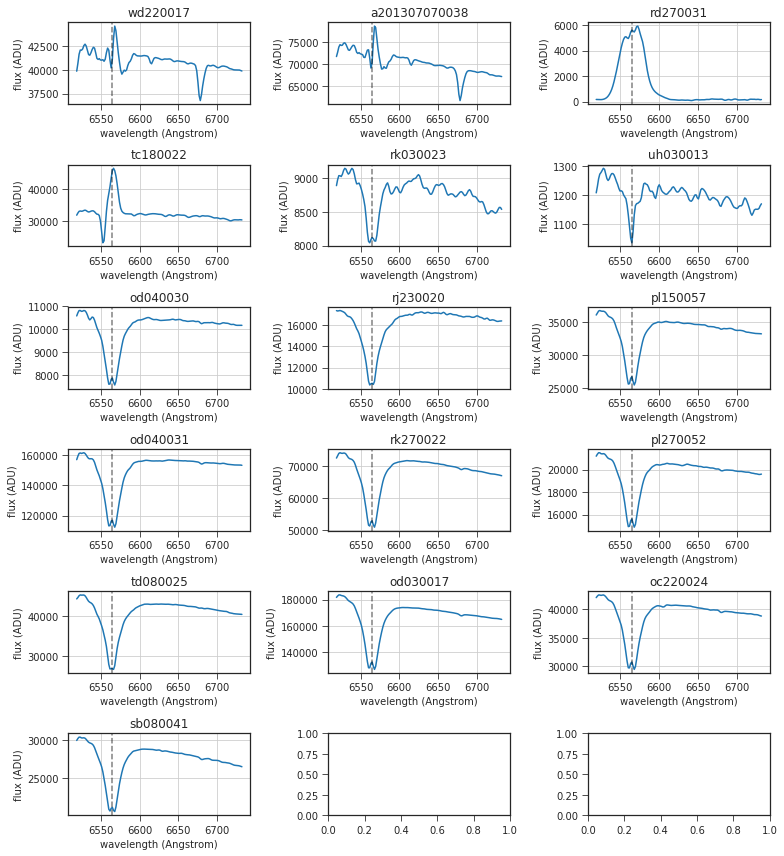

In [23]:
emissions = [
    'wd220017', 'a201307070038', 'rd270031',
    'tc180022', 'rk030023', 'uh030013',
    'od040030', 'rj230020', 'pl150057',
    'od040031', 'rk270022', 'pl270052',
    'td080025', 'od030017', 'oc220024',
    'sb080041'
]
plot_ids(emissions)

In [24]:
spectra.loc['qg130023', 'label'] = 'double-peak'
spectra.loc['od180011', 'label'] = 'double-peak'
spectra.loc['od150030', 'label'] = 'double-peak'
spectra.loc['wd220017', 'label'] = 'double-peak'
spectra.loc['a201307070038', 'label'] = 'double-peak'
spectra.loc['uh030013', 'label'] = 'absorption'

y = le.transform(spectra['label'])

## Train and Test Split

There is a specific thing to this dataset regarding train and test split.
The dataset contains spectra from same objects, for example because
some objects are observed periodically.
Figure below show 10 random spectra from 3 most common object in the dataset.
If the data were split randomly it might happen that very similar spectra
can be in both train and test set.
Therefore the data are split according to object names to avoid evaluation bias.

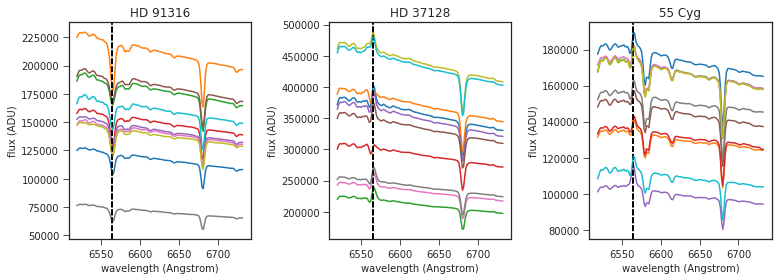

In [25]:
f, axes = pyplot.subplots(ncols=3, figsize=(11, 4))
objs = spectra['object'].value_counts().nlargest(3).index

for ax, obj in zip(axes, objs):
    ax.set_title(obj)
    all_idxs = numpy.argwhere(spectra['object'] == obj)
    rnd_idxs = numpy.random.choice(all_idxs.flat, size=10, replace=False)
    for idx in rnd_idxs:
        plot_flux(X[idx], ax=ax)

f.tight_layout()

In order to evaluate the final proposed preprocessing
procedure a test set of size 25% the original data
split out from the data.
It serves for final evaluation.
For ongoing evaluation of procedures which are about
to be tried and validation set of size 25% is taken out
of the train set with remains after the test set split.

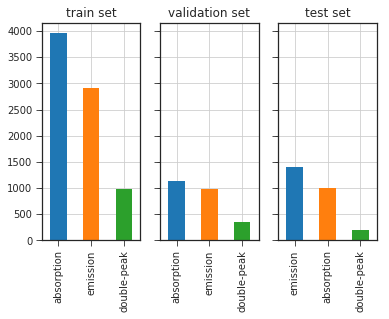

In [26]:
# seeds from TRNG https://www.random.org/
objects = spectra['object'].unique()
objects_tr, objects_te = model_selection.train_test_split(objects, random_state=15)
objects_tr, objects_va = model_selection.train_test_split(objects_tr, random_state=35)

idx_tr = spectra['object'].isin(objects_tr)
idx_va = spectra['object'].isin(objects_va)
idx_te = spectra['object'].isin(objects_te)

X_tr, y_tr = X[idx_tr], y[idx_tr]
X_va, y_va = X[idx_va], y[idx_va]
X_te, y_te = X[idx_te], y[idx_te]

f, (ax1, ax2, ax3) = pyplot.subplots(ncols=3, sharey=True)
ax1.set_title('train set')
spectra.loc[idx_tr, 'label'].value_counts().plot.bar(grid=True, ax=ax1)
ax2.set_title('validation set')
spectra.loc[idx_va, 'label'].value_counts().plot.bar(grid=True, ax=ax2)
ax3.set_title('test set')
spectra.loc[idx_te, 'label'].value_counts().plot.bar(grid=True, ax=ax3)

## Neural Network

Model used in this work is neural network with 3 layers:

- 40 input units,
- 64 units in hidden layer
- 3 units in output layer corresponding to 3 classes for classification.

This work is mostly concerned with preprocessing method so little focus should be
on the model.
But because of recent success of deep neural network in image recognition
and other areas ([natural language processing][npl], [Deep Q-network][dqn])
and the analogy of image and spectrum it was chosen.
Further there in no need for such complicated architecture as the
problem faced is much simpler.
Therefore, no convolutional layer are used and the model is very simple.

Activation function is [ReLU].
For training the [Adam] optimizer is used with default parameters.

[dropout]: http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf
[npl]: https://nlp.stanford.edu/
[dqn]: https://podondra.cz/deep-q-network-slides.html
[adam]: https://arxiv.org/abs/1412.6980
[relu]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [27]:
mlp = MLPClassifier(
    hidden_layer_sizes=[64],
    activation='relu',
    solver='adam',
    max_iter=200,
    tol=1e-4,
)

## Scaling

Normally, scaling is used to get features of different types to same range.
This work is faced with data from same domain and same units.
Thus scaling is used to make the spectra scale invariant
as the dataset is classified without any importance of scale.

This work assume that scaling is independent of balancing
so expereiments with scaling are done first
and then appropriate method for balancing will be found.

To compare different scaling methods classification accuracy will be measured.
To overcome the problem that the network might not always converge to same
parameters each method accuracy is mean of 30 runs.
For each methon the mean and also standard deviation is shown.

The result below shows that without scaling accuracy around 79%
can be achieved.

In [28]:
def evaluate_acc(X_tr, X_va, y_tr=y_tr, y_va=y_va, verbose=False):
    accs = []
    for i in range(30):
        mlp.fit(X_tr, y_tr)
        y_pred = mlp.predict(X_va)
        acc = accuracy_score(y_va, y_pred)
        if verbose:
            print(i, acc)
        accs.append(acc)
    return numpy.mean(accs), numpy.std(accs)

evaluate_acc(X_tr, X_va)

(0.7849302200751477, 0.054865793132987964)

Meanwhile for each scaling method a spectrum after
a transofrmation is going to be ploted to see what
effect the transfrotmation has.

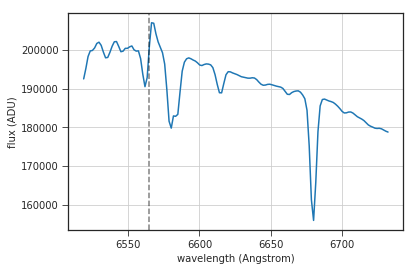

In [29]:
rnd_idx_tr = numpy.random.randint(len(X_tr))
plot_flux(X_tr[rnd_idx_tr])

### Standardization

Standardization transforms each spectrum to have unit mean
and zero variance.
This preprocessing method can improve significantly accuracy up to around 94%.

(0.9391035963499732, 0.0018210623138687316)

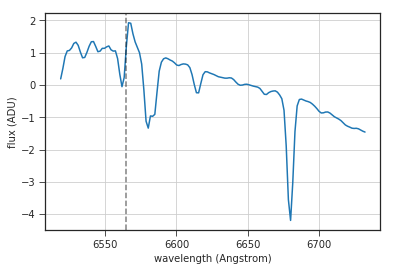

In [30]:
X_tr_scaled = preprocessing.scale(X_tr, axis=1)
X_va_scaled = preprocessing.scale(X_va, axis=1)
plot_flux(X_tr_scaled[rnd_idx_tr])
evaluate_acc(X_tr_scaled, X_va_scaled)

### Incorrect Standardization

This subsection proves the statement
that scaling each features is not worth it.
In comparison with scaling each individual spectra
in previous section the performance is much worse.

But when compared with raw data the accuracy is still improved.
This is probably caused by the fact that a neural network
can much better deal with centered data then with raw data (see [CS231n]).

[cs231n]: https://cs231n.github.io/neural-networks-2/

(0.8399355877616749, 0.02116638814807821)

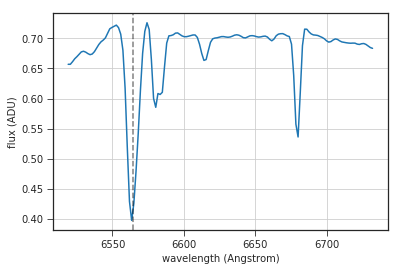

In [31]:
scaler = preprocessing.StandardScaler()
X_tr_scaled_ = scaler.fit_transform(X_tr)
X_va_scaled_ = scaler.transform(X_va)
plot_flux(X_tr_scaled_[rnd_idx_tr])
evaluate_acc(X_tr_scaled_, X_va_scaled_)

### Scaling to a Range

An alternative scaling is to lie between a given minimum and maximum value
or so that the maximum absolute value of each feature is scaled to unit size.

Firstly, min-max scaling to range $[0, 1]$ is presented
which given accuracy around 92%.

(0.9258454106280194, 0.005406528812946726)

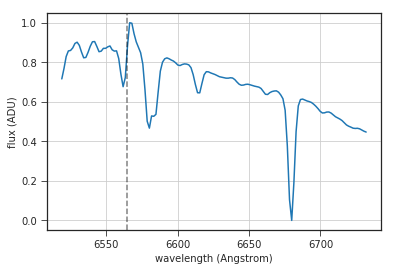

In [32]:
X_tr_minmax = preprocessing.minmax_scale(X_tr, axis=1)
X_va_minmax = preprocessing.minmax_scale(X_va, axis=1)
plot_flux(X_tr_minmax[rnd_idx_tr])
evaluate_acc(X_tr_minmax, X_va_minmax)

Secondly, min-max scaling to range $[-1, 1]$ is presented
which given accuracy around 93%.

(0.9299785292538915, 0.004122474111093937)

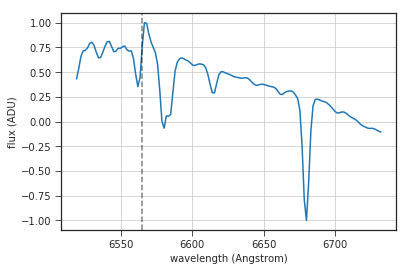

In [33]:
X_tr_minmax_ = preprocessing.minmax_scale(X_tr, feature_range=(-1, 1), axis=1)
X_va_minmax_ = preprocessing.minmax_scale(X_va, feature_range=(-1, 1), axis=1)
plot_flux(X_tr_minmax_[rnd_idx_tr])
evaluate_acc(X_tr_minmax_, X_va_minmax_)

Finnaly, max-abs scaling (division by maximal absolute value)
gives accuracy around 88%.

(0.8766505636070854, 0.0187980949715408)

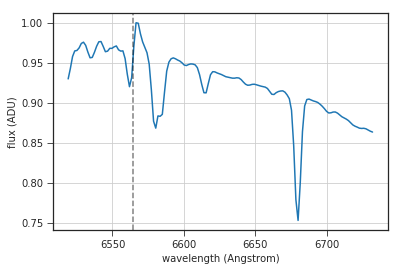

In [34]:
X_tr_maxabs = preprocessing.maxabs_scale(X_tr, axis=1)
X_va_maxabs = preprocessing.maxabs_scale(X_va, axis=1)
plot_flux(X_tr_maxabs[rnd_idx_tr])
evaluate_acc(X_tr_maxabs, X_va_maxabs)

To conclude best result are given by standardization of each spectrum.
But it is closely followeb by scaling to min-max scaling to $[-1, 1]$.

Conslusion is also that scaling is important
because it can imporve accurcy from around 79% to somewhere around 94%.

## Balancing

The learning phase and the subsequent prediction of machine
learning algorithms can be affected by the problem of
imbalanced data set.
The balancing issue corresponds to the difference of the
number of samples in the different classes. ([imblearn])

[imblearn]: http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

That is the exact situation of this dataset.
There is plenty of absorption spectra which is the usuall feature of stars.
Then there is less spectra in emission class which already are interesting.
Finally the double-peak class contains significantly small number of samples
in comparison with the other classes but it is the most intresting class.

Therefore it can be thought that a lot of spectra from the double-peak stars
will be missclassified as shown in confusion matrix bellow.

In [35]:
# source is http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_cm(cm, classes=le.classes_, normalize=True, cmap=pyplot.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.colorbar()
    tick_marks = numpy.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=0)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('true label')
    pyplot.xlabel('predicted label')

To evaluated different balancing method
an estimate of confusion matrix is used.
Each cell is mean of 30 runs for same reasons as in scaling.

Without any balancing the performance is on one hand
very good for absorption and emission spectra
but on the other hand poor for double-peak
where there is only around 64% double-peak correcly classified.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


absorption     3957
emission       2905
double-peak     978
dtype: int64

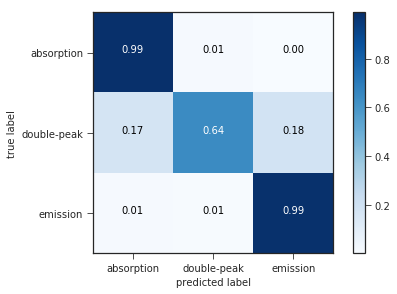

In [36]:
def evaluate_cm(X_tr, X_va, y_tr=y_tr, y_va=y_va, verbose=False):
    iters = 30
    cms = numpy.zeros((iters, 3, 3), dtype=numpy.int)
    for i in range(iters):
        mlp.fit(X_tr, y_tr)
        y_pred = mlp.predict(X_va)
        cm = confusion_matrix(y_va, y_pred)
        if verbose:
            print(cm)
        cms[i] = cm
    plot_cm(cms.mean(axis=0))
    return pandas.Series(le.inverse_transform(y_tr)).value_counts()

evaluate_cm(X_tr_scaled, X_va_scaled)

### Random Over-sampling

Random over-sampling improves the performance on double-peak spectra to around 69%
and there is only small decrease in other classes.
This is the expected behavior as the network is know not biased to the majority classes.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


double-peak    3957
emission       3957
absorption     3957
dtype: int64

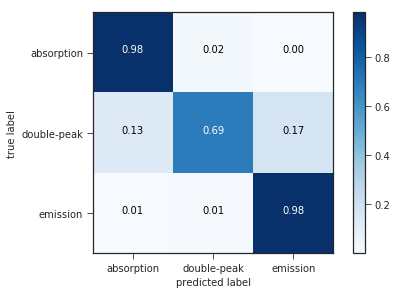

In [37]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_tr_scaled, y_tr)
evaluate_cm(X_ros, X_va_scaled, y_tr=y_ros)

### Random Under-sampling

Suprisingly random under-sampling is better than random over-sampling.
It is not really big different but it is
although there is lost of around 5000 training data which are not used at all.
Probably there not that big problem with classification on the overlapping
region as the number of samples there might be reduced.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


double-peak    978
emission       978
absorption     978
dtype: int64

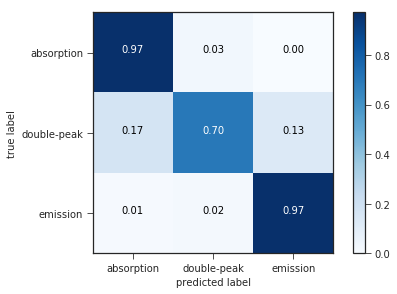

In [38]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_tr_scaled, y_tr)
evaluate_cm(X_rus, X_va_scaled, y_tr=y_rus)

### Tomek's Links

Tomek's links is under sampling technique
which heuristically remove samples from place in features
space where are points from different classes close to each other.

It this case its performance is very bad
because it is very close to performance without balancing.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


absorption     3941
emission       2888
double-peak     978
dtype: int64

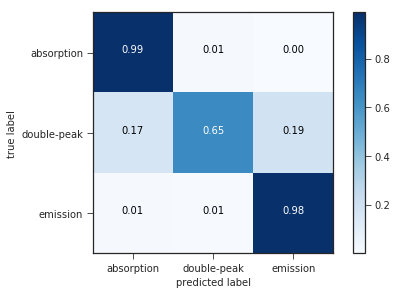

In [39]:
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_sample(X_tr_scaled, y_tr)
evaluate_cm(X_tomek, X_va_scaled, y_tr=y_tomek)

### Synthetic Minority Over-sampling Technique

[SMOTE] is over-sampling approach in which the minority class is over-sampled
by creating synthetic samples.
A new sample is created along line from a sample to its all
or any k nearest neighbors from same class.
Difference between feature vectors of sample under consideration and nearest neighbor is taken.
It is multiply by random number between 0 and 1.

[smote]: https://arxiv.org/abs/1106.1813

SMOTE gets scores very same as under and over-sampling.
Moreover, it is generating syntetic stars which is strange to image.
Therefore the previous technique are more reasonable then this one.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


double-peak    3957
emission       3957
absorption     3957
dtype: int64

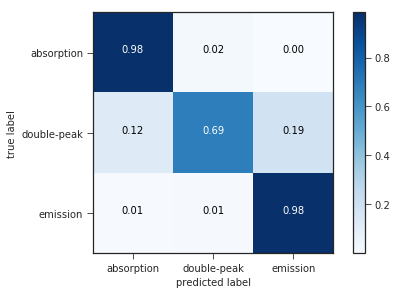

In [40]:
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X_tr_scaled, y_tr)
evaluate_cm(X_smote, X_va_scaled, y_tr=y_smote)

### SMOTEENN

SMOTEENN combines over and under sampling using SMOTE and Edited Nearest Neighbours ([ENN]).
Thus it should outperform original SMOTE
but on spectral data it did not as the confusion matrix shows.

[enn]: https://link.springer.com/chapter/10.1007/978-3-642-13278-0_39

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


emission       3867
absorption     3843
double-peak    3836
dtype: int64

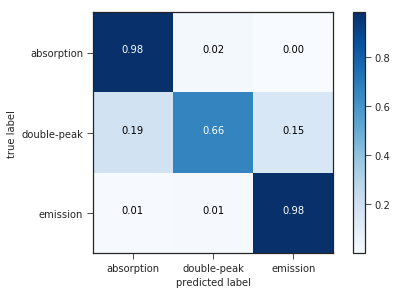

In [41]:
smoteenn = SMOTEENN()
X_smoteenn, y_smoteenn = smoteenn.fit_sample(X_tr_scaled, y_tr)
evaluate_cm(X_smoteenn, X_va_scaled, y_tr=y_smoteenn)

### Adaptive Synthetic Sampling Approach

Adaptive Synthetic ([ADASYN]) Sampling Approach for Imbalanced Learning is
based on SMOTE and the idea of adaptively generating minority data
samples according to their distributions: more synthetic data
is generated for minority class samples that are harder to learn
compared to those minority samples that are easier to learn.

[adasyn]: https://doi.org/10.1109/ijcnn.2008.4633969

This method bring significant improvement on spectral data.
Accuracy of double-peak spectra classification is 81%.
There is small drop in absorption spectra classification
but it is tiny in comparison with the increase.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


double-peak    3993
absorption     3957
emission       3928
dtype: int64

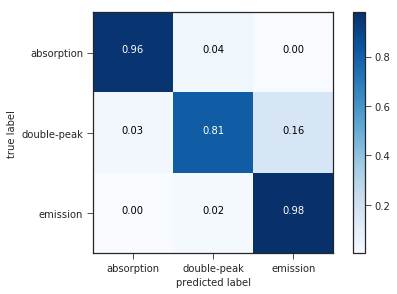

In [42]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_sample(X_tr_scaled, y_tr)
evaluate_cm(X_adasyn, X_va_scaled, y_tr=y_adasyn)

## Evaluation on Test Set

To see how succesfull can the found method really be
their are tested on previously unseen data.
Therefore future preformance of such preprocessing method
with the neural network model can be estimated.

Test is firstly run with training set only consisting of training
data and then with training set
which contains both train and validation data.
Thus, it can be estimated how important is the amount of data
provided to the neural network.

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


double-peak    3993
absorption     3957
emission       3928
dtype: int64

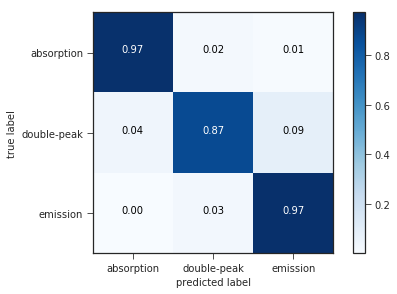

In [43]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_sample(X_tr_scaled, y_tr)
X_te_scaled = preprocessing.scale(X_te, axis=1)

evaluate_cm(X_adasyn, X_te_scaled, y_tr=y_adasyn, y_va=y_te)

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


emission       5130
double-peak    5111
absorption     5101
dtype: int64

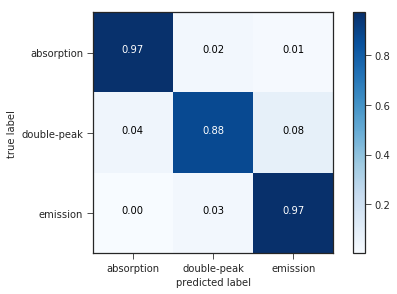

In [44]:
X_tr_va = numpy.concatenate((X_tr, X_va))
y_tr_va = numpy.concatenate((y_tr, y_va))

X_tr_va_scaled = preprocessing.scale(X_tr_va, axis=1)

adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_sample(X_tr_va_scaled, y_tr_va)
X_te_scaled = preprocessing.scale(X_te, axis=1)

evaluate_cm(X_adasyn, X_te_scaled, y_tr=y_adasyn, y_va=y_te)

/home/podondra/mi-pdd/ondrejov-preprocessing/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


absorption     5101
emission       3888
double-peak    1335
dtype: int64

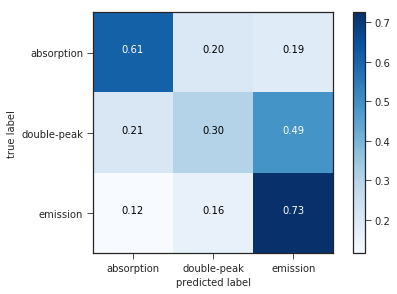

In [45]:
X_tr_va = numpy.concatenate((X_tr, X_va))
y_tr_va = numpy.concatenate((y_tr, y_va))
evaluate_cm(X_tr_va, X_te_scaled, y_tr=y_tr_va, y_va=y_te)

These results show that without the preprocessing methods the classication
is much worse.

## Conclusion

This section sum ups the results of this work.
Firstly with data visualization and dimensionality reduction
predictions about the data classification were made.
It was proposed that the classification of double-peak spectra
would be harder than the other two classes
which is proved by the classification results.

Then using supervised dimensionality reduction
some classified spectra were found thus
the dataset was cleaned.
Also 4 spectra without object name were identified.

To prevent overfitting the dataset was split according to
obeject names. Also a validation set was left out so
is was possible to show in previous section
expected performance of proposed preprocessing method
when combines with neural network classifier.

Several scaling method were tried and standard scaling of
each spectra was evaluated as best.
It was found that balancing the dataset can improve
performance on double-peak spectra using ADASYN method.

Finally, the techniques were evaluated on test set
giving performance shown in confusion matrices above.